In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tsai.all as ts
import torch
from torch import nn
from my_utilities import time_frequency_analysis, mma_Partition, time_frequency_analysis_output_1s
from sklearn.linear_model import RidgeClassifierCV

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tsai.all as ts
import torch
from torch import nn
from my_utilities import time_frequency_analysis, mma_Partition, time_frequency_analysis_output_1s
from sklearn.linear_model import RidgeClassifierCV
from scipy import stats

from sklearn.metrics import confusion_matrix
import time

import time
import mne

In [ ]:
srate = 2000
new_srate = 200
sec = 1 # time step length
ele = pd.read_csv('data/ele_4_60_hz.csv', header = None, index_col = None).to_numpy()
# shape = (4, 15, 2, 20000, 14)

ele = np.reshape(
    ele, (20000,15,4,2,14), order = 'F').transpose([2,1,3,0,4])[:,:,:,srate::srate//new_srate,:]


ear_ele = ele[...,:8].astype(np.float32).reshape(-1,int(200 * sec),8)
head_ele = ele[...,8:].astype(np.float32).reshape(-1,int(200 * sec),6)

In [154]:
ear_raw = mne.io.RawArray(np.vstack(ear_ele).T,  
                          mne.create_info(ch_names= 8, sfreq = new_srate, ch_types='eeg'))

# ear_raw = mne.io.RawArray(np.vstack(head_ele).T,  
#                           mne.create_info(ch_names= 6, sfreq = new_srate, ch_types='eeg'))

Creating RawArray with float64 data, n_channels=8, n_times=216000
    Range : 0 ... 215999 =      0.000 ...  1079.995 secs
Ready.


In [155]:
ica = mne.preprocessing.ICA(
    n_components=8, method='picard', max_iter='auto', random_state=97)

In [156]:
ica.fit(ear_raw)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 2.9s.


Method,picard
Fit,32 iterations on raw data (216000 samples)
ICA components,8
Available PCA components,8
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=8, n_times=216000
    Range : 0 ... 215999 =      0.000 ...  1079.995 secs
Ready.


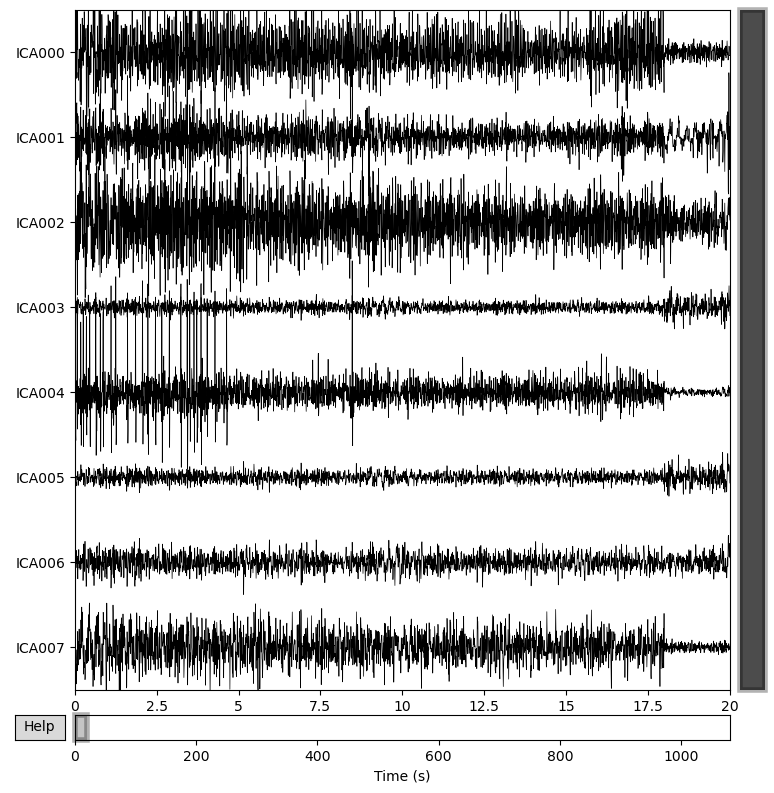

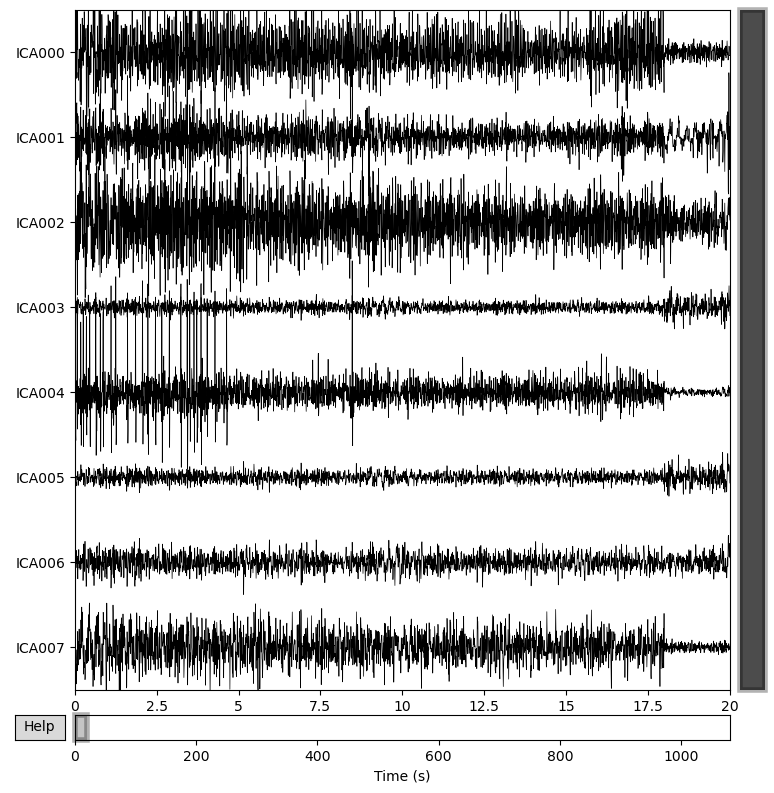

In [157]:
ica.plot_sources(ear_raw)

In [158]:
muscle_idx = [1]

ear_raw_removed = ica.apply(ear_raw, exclude = muscle_idx)

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components


In [159]:
removed_earEEG = ear_raw_removed._data.T.reshape(-1, 200, 8)
removed_earEEG.shape

(1080, 200, 8)

In [160]:
# ear_5hz = removed_earEEG.reshape(4, -1, 200, 8)[0]
# ear_7hz = removed_earEEG.reshape(4, -1, 200, 8)[1]
# ear_9hz = removed_earEEG.reshape(4, -1, 200, 8)[2]
# ear_11hz = removed_earEEG.reshape(4, -1, 200, 8)[3]

In [161]:
# from tensorflow.data import Dataset

In [162]:
# # i=3
# xx1, yy1, zz1 = time_frequency_analysis(ear_7hz[i], 
#                                         srate = new_srate, 
#                                         min_freq = 2, max_freq = 60, num_freq = 59, fwhm = 3)
# xx2, yy2, zz2 = time_frequency_analysis(ear_11hz[i], 
#                                         srate = new_srate,  
#                                         min_freq = 2, max_freq = 60, num_freq = 59, fwhm = 3)
# # zz1[:3] = 0
# # zz2[:3] = 0


# plt.figure(1, figsize = (15, 8))
# plt.clf()
# plt.subplot(1,2,1)
# plt.contourf(xx1, yy1[3:], zz1[3:],
#              40, cmap=cm.jet)  # , vmin = 0, vmax = 2)
# plt.yticks(ticks = np.arange(5,61,1))
# plt.colorbar()
# plt.title('7hz')

# plt.subplot(1,2,2)
# plt.contourf(xx2, yy2[3:], zz2[3:],
#              40, cmap=cm.jet)  # , vmin = 0, vmax = 2)
# plt.yticks(ticks = np.arange(5,61,1))
# plt.colorbar()
# plt.title('11hz')
# plt.show()
# i += 1
# # plt.savefig('paper/5hz_4s.png')

In [163]:
def cross_validation(x1, y, cv_number = 20, test_size = 0.1):
    acc = []
    batch_tfms = [ts.TSStandardize(by_sample=True)]
    tfms  = [None, [ts.Categorize()]]
    cfm = np.zeros([4,4])
    for _ in np.arange(cv_number):
        x1,  y = shuffle(x1, y)
        splits = ts.get_splits(y, valid_size= test_size, stratify=True, shuffle=True,
                               random_state=42)
            

        dls_x1 = ts.get_ts_dls(x1, y, 
                         splits=splits, 
                         tfms=tfms, drop_last=False, 
                         shuffle_train=False, batch_tfms=batch_tfms, bs=10_000)
        
        
        for dls in [dls_x1]:
            model = ts.build_ts_model(ts.ROCKET, dls=dls)

            X_train, y_train = ts.create_rocket_features(dls.train, model)
            X_valid, y_valid = ts.create_rocket_features(dls.valid, model)
            X_train.shape, X_valid.shape

            ridge = RidgeClassifierCV(alphas=np.logspace(-8, 8, 17), normalize=True)
            ridge.fit(X_train, y_train)
            print(f'alpha: {ridge.alpha_:.2E}  train: {ridge.score(X_train, y_train):.5f}  valid: {ridge.score(X_valid, y_valid):.5f}')
            acc.append(ridge.score(X_valid, y_valid))

            cfm += confusion_matrix(y_valid, ridge.predict(X_valid))
            print(cfm)
    return acc, cfm

In [164]:
removed_earEEG.shape

(1080, 200, 8)

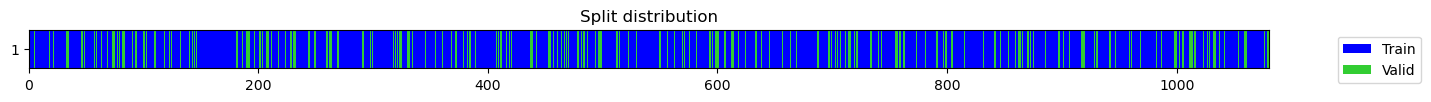

alpha: 1.00E+02  train: 0.62731  valid: 0.44907
[[21.  7. 12. 14.]
 [ 8. 27. 10.  9.]
 [ 8. 11. 21. 14.]
 [ 4.  8. 14. 28.]]


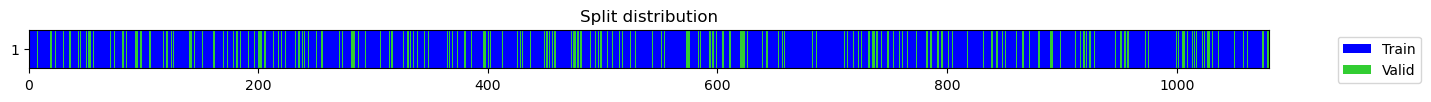

alpha: 1.00E+02  train: 0.63426  valid: 0.43056
[[46. 17. 22. 23.]
 [18. 52. 22. 16.]
 [20. 21. 44. 23.]
 [19. 16. 25. 48.]]


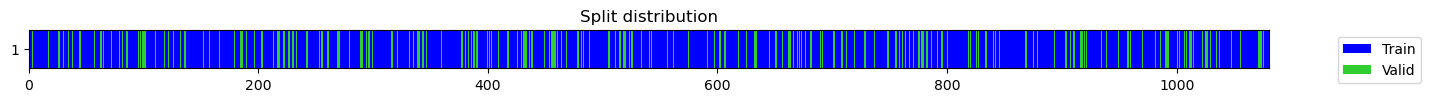

alpha: 1.00E+02  train: 0.62731  valid: 0.46296
[[70. 24. 32. 36.]
 [28. 81. 32. 21.]
 [32. 28. 67. 35.]
 [27. 26. 37. 72.]]


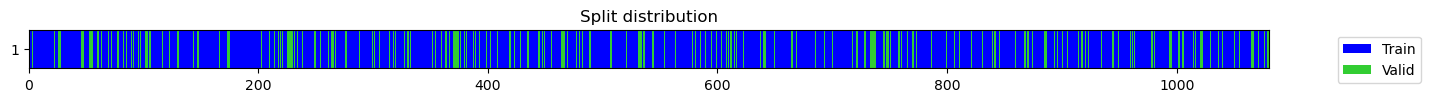

alpha: 1.00E+02  train: 0.62963  valid: 0.44444
[[ 94.  30.  43.  49.]
 [ 36. 111.  42.  27.]
 [ 42.  39.  85.  50.]
 [ 33.  31.  56.  96.]]


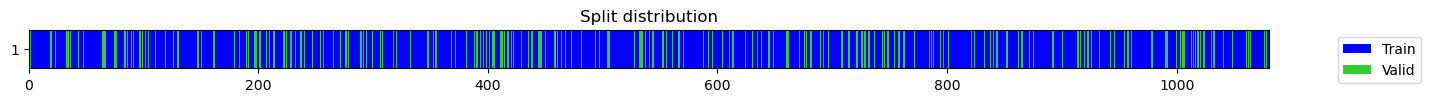

alpha: 1.00E+02  train: 0.63657  valid: 0.41667
[[114.  47.  54.  55.]
 [ 49. 134.  49.  38.]
 [ 52.  50. 113.  55.]
 [ 42.  44.  69. 115.]]


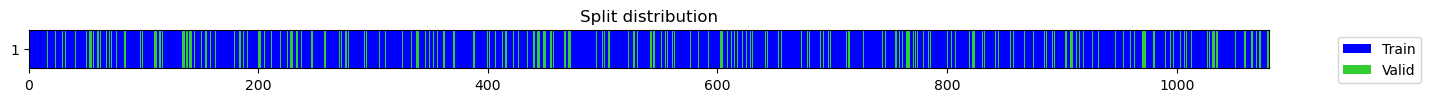

alpha: 1.00E+02  train: 0.63310  valid: 0.44444
[[135.  56.  68.  65.]
 [ 60. 161.  56.  47.]
 [ 61.  62. 135.  66.]
 [ 54.  53.  76. 141.]]


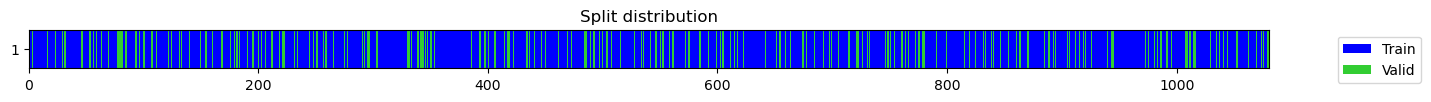

alpha: 1.00E+01  train: 0.92130  valid: 0.42593
[[157.  61.  86.  74.]
 [ 72. 186.  67.  53.]
 [ 73.  67. 160.  78.]
 [ 66.  64.  87. 161.]]


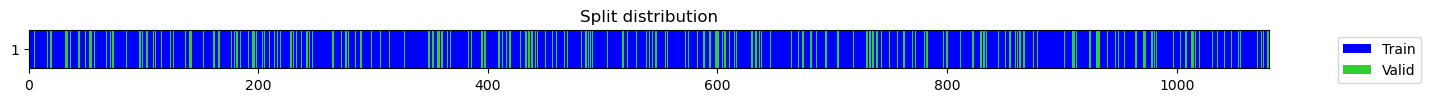

alpha: 1.00E+02  train: 0.62963  valid: 0.42593
[[180.  71.  99.  82.]
 [ 83. 215.  77.  57.]
 [ 91.  74. 177.  90.]
 [ 77.  73.  98. 184.]]


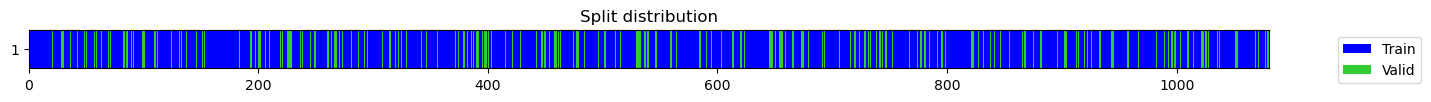

alpha: 1.00E+02  train: 0.64352  valid: 0.49074
[[203.  83. 108.  92.]
 [ 91. 246.  85.  64.]
 [101.  83. 202. 100.]
 [ 90.  79. 106. 211.]]


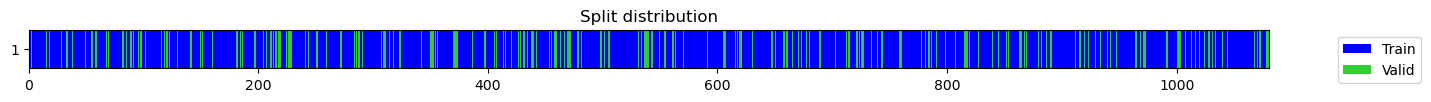

alpha: 1.00E+02  train: 0.61921  valid: 0.47222
[[231.  91. 119.  99.]
 [ 98. 278.  93.  71.]
 [117.  90. 219. 114.]
 [102.  84. 118. 236.]]


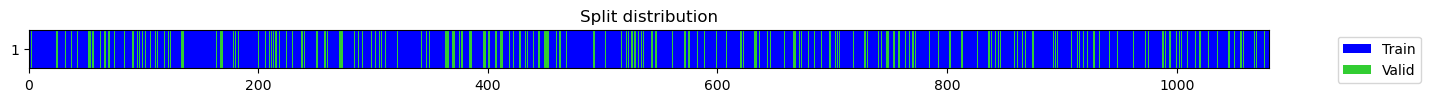

alpha: 1.00E+02  train: 0.63194  valid: 0.49537
[[254. 105. 128. 107.]
 [111. 307. 100.  76.]
 [123. 100. 246. 125.]
 [108.  96. 126. 264.]]


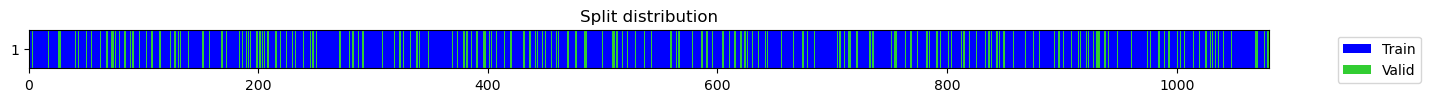

alpha: 1.00E+02  train: 0.62269  valid: 0.47685
[[279. 113. 141. 115.]
 [117. 334. 114.  83.]
 [131. 113. 268. 136.]
 [118. 105. 132. 293.]]


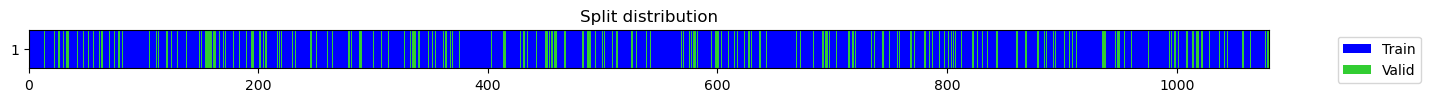

alpha: 1.00E+02  train: 0.61111  valid: 0.47222
[[305. 121. 149. 127.]
 [128. 365. 121.  88.]
 [138. 120. 298. 146.]
 [132. 118. 144. 308.]]


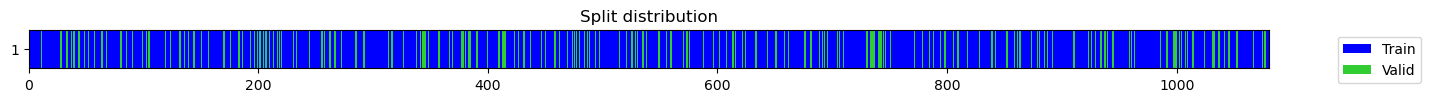

alpha: 1.00E+02  train: 0.63657  valid: 0.41204
[[325. 134. 157. 140.]
 [137. 393. 131.  95.]
 [153. 129. 317. 157.]
 [144. 127. 155. 330.]]


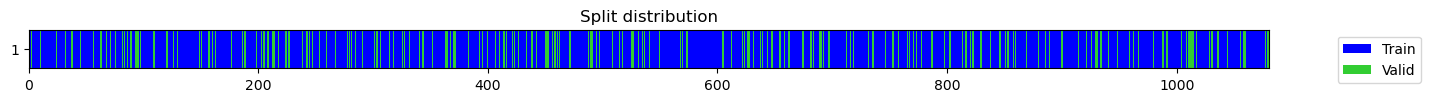

alpha: 1.00E+02  train: 0.62847  valid: 0.48148
[[354. 144. 162. 150.]
 [149. 416. 143. 102.]
 [161. 140. 340. 169.]
 [152. 135. 164. 359.]]


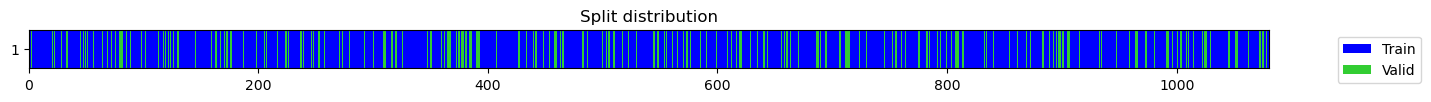

alpha: 1.00E+02  train: 0.62384  valid: 0.46759
[[377. 156. 174. 157.]
 [154. 448. 154. 108.]
 [164. 154. 366. 180.]
 [155. 149. 181. 379.]]


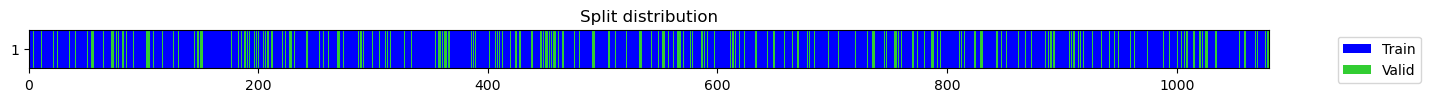

alpha: 1.00E+02  train: 0.63773  valid: 0.46296
[[403. 164. 183. 168.]
 [163. 474. 160. 121.]
 [176. 164. 389. 189.]
 [163. 160. 191. 404.]]


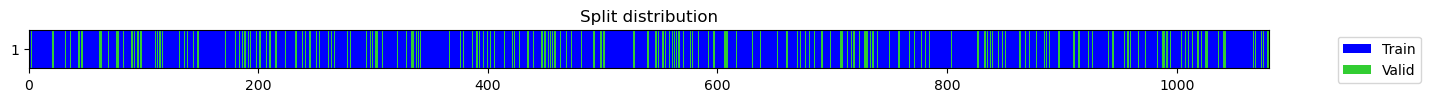

alpha: 1.00E+02  train: 0.63542  valid: 0.43519
[[426. 172. 195. 179.]
 [170. 504. 164. 134.]
 [188. 178. 411. 195.]
 [173. 173. 203. 423.]]


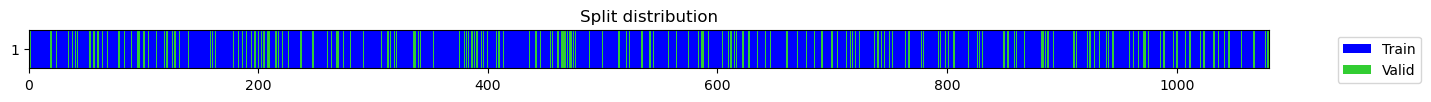

alpha: 1.00E+01  train: 0.91435  valid: 0.44907
[[448. 181. 208. 189.]
 [179. 525. 178. 144.]
 [192. 184. 440. 210.]
 [185. 179. 214. 448.]]


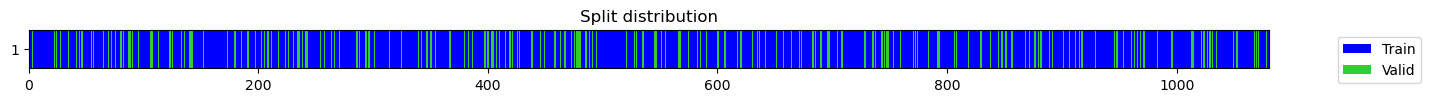

alpha: 1.00E+02  train: 0.62384  valid: 0.43981
[[469. 190. 219. 202.]
 [195. 549. 186. 150.]
 [201. 197. 464. 218.]
 [193. 188. 225. 474.]]


In [165]:
ear_ele = removed_earEEG.transpose([0, 2, 1])
y = np.repeat([0,1,2,3], int(ear_ele.shape[0]/4))

# z-score
ear_ele = (ear_ele - ear_ele.mean(axis = 2)[...,np.newaxis])\
                /ear_ele.std(axis = 2)[...,np.newaxis]




# time frequency analysis for ear-EEG
temp_ear_ele = []
for flame in ear_ele:
    _,_,temp = time_frequency_analysis(
        flame.T, srate = new_srate, max_freq = 60, min_freq = 2, 
        num_freq = 59, fwhm = 0.75 * sec)

    temp_ear_ele.append(temp)

# if use mask
ear_ele_NOmask = np.asarray(temp_ear_ele)
# ear_ele_masked = np.asarray(temp_ear_ele)[:,mask,:]
# print(ear_ele.shape)
temp_acc, cf_matrix = cross_validation(ear_ele_NOmask,
                                       y, cv_number = 20, test_size = 0.2)
# pd.concat([pd.read_csv(r'result/ROCKET_ACC_with_mask.csv', header = 0),
#            pd.DataFrame(np.asarray(temp_acc).reshape(-1, 2), 
#                         columns=[f'{time_in_sec}s_NOmask', f'{time_in_sec}s_masked'])], 
#       axis = 1).to_csv(r'result/ROCKET_ACC_with_mask.csv', index= None)

#     pd.DataFrame(cf_matrix).to_csv(
#         r'C:\MY\matlab\SSVEP\seesion2\result\ROCKET_cfmatrix_01_13.csv', 
#         mode = 'a', index = None, header = None)
# total_acc.append(temp_acc)